### 1. Input Data

- ***Read Input Data:***

In [3]:
import numpy as np
import time

# List of filenames to process
file_names = ['OAS0.txt', 'OAS1.txt', 'OAS2.txt', 'OAS3.txt', 'OAS4.txt', 'OAS5.txt', 'OAS6.txt']

def readInput(fileName):
    """
    Read the input data from a file and return relevant arrays.
    """
    file0 = open(fileName, 'r')
    
    # Python will read the entire file as floats, since 1 row contains floating point numbers.
    # However, we want to store all other data as integers.
    data = np.loadtxt(fileName)

    duration = data[0].astype(int)  # First line of file holds duration for each order
    profit = data[1].astype(int)  # Second line: profit for each order
    dueDate = data[2].astype(int)  # Third: due date
    deadline = data[3].astype(int)  # Fourth: deadline
    tardCost = data[4]  # Fifth: tardiness cost
    numberOrders = len(duration)  # Can be derived from the length of any of the above

    setup = np.zeros((numberOrders, numberOrders)).astype(int)  # Empty array for setup
    index = 0
    while index < numberOrders:
        setup[index] = data[5 + index].astype(int)  # 5 is here to make sure Python starts with line 5 of input file
        index += 1

    file0.close()

    return duration, profit, dueDate, deadline, tardCost, numberOrders, setup

### 2. Functions

In [4]:
from itertools import permutations

'''Start Times Calculation'''
def cal(duration, setup, sequence):
    """Calculate start and finish times for a given sequence."""
    num_orders = len(sequence)
    start_times = np.zeros(num_orders)
    finish_times = np.zeros(num_orders)

    # Initial order
    start_times[0] = 0
    finish_times[0] = duration[sequence[0]]

    # Compute times for subsequent orders
    for i in range(1, num_orders):
        prev_order = sequence[i - 1]
        current_order = sequence[i]
        start_times[i] = finish_times[i - 1] + setup[prev_order][current_order]
        finish_times[i] = start_times[i] + duration[current_order]

    return start_times, finish_times


'''Feasibility Check and Profit Calculation'''

def eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence):
    """Evaluate a given sequence for feasibility and objective value."""
    num_orders = len(sequence)
    start_times = np.zeros(num_orders)
    finish_times = np.zeros(num_orders)
    infeasible = False

    # Initial order
    start_times[0] = 0
    finish_times[0] = duration[sequence[0]]

    # Compute times for subsequent orders
    for i in range(1, num_orders):
        prev_order = sequence[i - 1]
        current_order = sequence[i]
        start_times[i] = finish_times[i - 1] + setup[prev_order][current_order]
        finish_times[i] = start_times[i] + duration[current_order]

    total_profit = 0
    total_tardiness_cost = 0

    for idx, order in enumerate(sequence):
        # Overlapping tasks
        if idx > 0 and start_times[idx] < finish_times[idx - 1]:
            infeasible = True
            return None # Return None for infeasible solution

        # Deadline exceeded
        if finish_times[idx] > deadline[order]:
            infeasible = True   
            return None # Return None for infeasible solution

        # Profit or tardiness calculation
        if finish_times[idx] <= dueDate[order]:
            total_profit += profit[order]
        else:
            tardiness = finish_times[idx] - dueDate[order]
            total_tardiness_cost += tardiness * tardCost[order]

    # Return None for infeasible solutions
    if infeasible:
        print("There is no feasible solution.")

    return total_profit - total_tardiness_cost


### 4 Greedy construction heuristics

#### **4.1 Insertion Heuristic**

In [5]:
def insertion(duration, profit, dueDate, deadline, tardCost, numberOrders, setup):
    """
    Greedy insertion heuristic for scheduling.
    Always adds the order that maximizes profit.
    """
    remaining_orders = list(range(numberOrders))  
    scheduled_orders = []  
    total_profit = 0  

    while remaining_orders:
        best_order = None
        best_profit = total_profit

        # Evaluate each remaining order for sequential addition
        for order in remaining_orders:
            # Create a tentative schedule by appending an order.
            tentative_schedule = scheduled_orders + [order]

            # Calculate the profit of the tentative schedule
            start_times, _ = cal(duration, setup, tentative_schedule)
            current_profit = eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, tentative_schedule)

            # Update the best order if it improves the profit
            if current_profit is not None and current_profit > best_profit:
                best_order = order
                best_profit = current_profit

        # Add the best order found to the schedule
        if best_order is not None:
            scheduled_orders.append(best_order)
            total_profit = best_profit
            remaining_orders.remove(best_order)
        else:
            # If no feasible order can be added, stop
            break

    return scheduled_orders, total_profit

In [6]:
print('Results using Insertion() Greedy Heuristics')
# Loop over each file, read the data, and run the insertion heuristic
for file_name in file_names:
    start_time = time.time()  # Record the start time

    # Read input data
    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)

    # Run the insertion heuristic to get the schedule and total profit
    scheduled_orders, total_profit = insertion(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)

    end_time = time.time()  # Record the end time

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    # Convert to one-based indexing for display
    scheduled_orders_ = [order + 1 for order in scheduled_orders]

    # Print the results for this file
    print(f"Results for {file_name} using insertion():")
    print(f"Scheduled Orders: {scheduled_orders_}")
    print(f"Total Profit: {total_profit}")
    print(f"Run Time: {elapsed_time:.4f} seconds")
    print("-" * 50)


Results using Insertion() Greedy Heuristics
Results for OAS0.txt using insertion():
Scheduled Orders: [1]
Total Profit: 10
Run Time: 0.0170 seconds
--------------------------------------------------
Results for OAS1.txt using insertion():
Scheduled Orders: [8, 2, 4, 10]
Total Profit: 304
Run Time: 0.0140 seconds
--------------------------------------------------
Results for OAS2.txt using insertion():
Scheduled Orders: [10, 14, 4, 1, 7]
Total Profit: 377
Run Time: 0.0169 seconds
--------------------------------------------------
Results for OAS3.txt using insertion():
Scheduled Orders: [11, 10, 12, 8, 19, 5, 1, 17, 3]
Total Profit: 634
Run Time: 0.0180 seconds
--------------------------------------------------
Results for OAS4.txt using insertion():
Scheduled Orders: [2, 8, 15, 6, 10, 4, 16, 22, 17, 12, 25, 14, 19, 23, 5]
Total Profit: 762
Run Time: 0.0268 seconds
--------------------------------------------------
Results for OAS5.txt using insertion():
Scheduled Orders: [30, 3, 13, 37

- ***Visualization :***

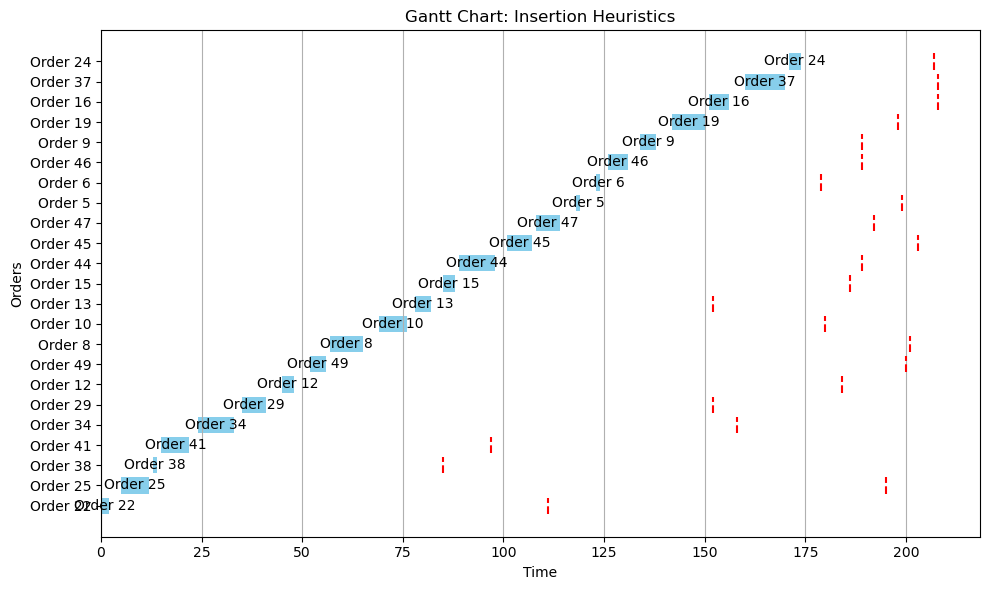

In [7]:
import matplotlib.pyplot as plt

def visualize_gantt(duration, setup, deadline, scheduled_orders):
    """
    Function to visualize the schedule using a Gantt chart.
    """
    if not scheduled_orders:
        print("No scheduled orders to visualize.")
        return

    num_orders = len(scheduled_orders)
    start_times = [0] * num_orders
    finish_times = [0] * num_orders

    # Calculate start and finish times for each order
    for i, order in enumerate(scheduled_orders):
        if i == 0:
            start_times[i] = 0
        else:
            prev_order = scheduled_orders[i - 1]
            start_times[i] = finish_times[i - 1] + setup[prev_order][order]
        finish_times[i] = start_times[i] + duration[order]

    # Create the Gantt chart
    plt.figure(figsize=(10, 6))

    for i, order in enumerate(scheduled_orders):
        # Plot the bar for each order
        plt.barh(i, finish_times[i] - start_times[i], left=start_times[i], color='skyblue')
        plt.text(start_times[i] + (finish_times[i] - start_times[i]) / 2, i,
                 f"Order {order + 1}", ha='center', va='center', fontsize=10)

        # Plot the deadline line
        plt.vlines(deadline[order], i - 0.4, i + 0.4, color='red', linestyle='--')

    # Set labels and title
    plt.yticks(range(num_orders), [f"Order {order + 1}" for order in scheduled_orders])
    plt.xlabel("Time")
    plt.ylabel("Orders")
    plt.title("Gantt Chart: Insertion Heuristics")
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

visualize_gantt(duration, setup, deadline, scheduled_orders)


#### **4.2 Savings Heuristic**

- ***code :***

In [8]:
def savings(duration, profit, dueDate, deadline, tardCost, numberOrders, setup, max_duration):
    """
    Savings heuristic: Starts from a solution with all orders (infeasible) and iteratively remove
    the order with the lowest profit until the solution is feasible, ensuring no overlaps, deadlines are met,
    and total duration does not exceed desired duration.
    """
    # Start with all orders in the solution (neglect infeasibility)
    scheduled_orders = list(range(numberOrders))
    
    # Calculate initial start and finish times
    start_times, finish_times = cal(duration, setup, scheduled_orders)
    total_duration = finish_times[-1] if finish_times.size > 0 else 0  # Total duration based on the last finish time
    
    # Check if the initial schedule is feasible
    if savings_feasible(start_times, finish_times, scheduled_orders, deadline, total_duration, max_duration):
        total_profit = sum(profit[o] for o in scheduled_orders)  # Total profit of all scheduled orders
        return scheduled_orders, total_profit

    # Keep removing the order with the lowest profit until the solution is feasible
    while not savings_feasible(start_times, finish_times, scheduled_orders, deadline, total_duration, max_duration) and scheduled_orders:
        # Find the order with the lowest profit
        min_profit_order = min(scheduled_orders, key=lambda o: profit[o])
        
        # Remove the order with the lowest profit
        scheduled_orders.remove(min_profit_order)
        
        # Recalculate start and finish times
        start_times, finish_times = cal(duration, setup, scheduled_orders)
        total_duration = finish_times[-1] if finish_times.size > 0 else 0

    # Calculate the total profit for the feasible schedule
    total_profit = sum(profit[o] for o in scheduled_orders)

    return scheduled_orders, total_profit , total_duration


def savings_feasible(start_times, finish_times, scheduled_orders, deadline, total_duration, max_duration):
    """
    Checks if the solution is feasible based on the provided conditions:
    1. Tasks must not overlap.
    2. No task can exceed its deadline.
    3. Total duration must not exceed max_duration.
    """
    for idx, order in enumerate(scheduled_orders):
        # Overlapping tasks
        if idx > 0 and start_times[idx] < finish_times[idx - 1]:
            return False  # Overlap detected
        
        # Deadline exceeded
        if finish_times[idx] > deadline[order]:
            return False  # Deadline violation detected

    # Check if total duration exceeds the allowed max duration
    if total_duration > max_duration:
        return False  # Total duration violation detected

    return True  # All conditions satisfied

In [9]:
print('Results using savings() Greedy Heuristics')
# Loop over each file, read the data, and run the savings function
for file_name in file_names:
    start_time = time.time()  # Record the start time

    # Read input data
    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)

    # Example maximum duration constraint
    max_duration = 100  # Set your desired total duration limit
    
    # Run the savings function to get the schedule and total profit
    scheduled_orders, total_profit, total_duration = savings(duration, profit, dueDate, deadline, tardCost, numberOrders, setup, max_duration)

    end_time = time.time()  # Record the end time

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    # Convert to one-based indexing for display
    scheduled_orders_ = [order + 1 for order in scheduled_orders]

    # Print the results for this file
    print(f"Results for {file_name}:")
    print(f"Scheduled Orders: {scheduled_orders_}")
    print(f"Total Profit: {total_profit}")
    print(f"Total Duration: {total_duration}")
    print(f"Run Time: {elapsed_time:.4f} seconds")
    print("-" * 50)


Results using savings() Greedy Heuristics
Results for OAS0.txt:
Scheduled Orders: [1]
Total Profit: 10
Total Duration: 4.0
Run Time: 0.0030 seconds
--------------------------------------------------
Results for OAS1.txt:
Scheduled Orders: [1, 2, 8, 9]
Total Profit: 322
Total Duration: 35.0
Run Time: 0.0010 seconds
--------------------------------------------------
Results for OAS2.txt:
Scheduled Orders: [4, 10, 14]
Total Profit: 264
Total Duration: 19.0
Run Time: 0.0030 seconds
--------------------------------------------------
Results for OAS3.txt:
Scheduled Orders: [10, 11, 13]
Total Profit: 280
Total Duration: 23.0
Run Time: 0.0021 seconds
--------------------------------------------------
Results for OAS4.txt:
Scheduled Orders: [2, 3, 4, 6, 8, 10, 15, 16, 17, 18, 22, 27]
Total Profit: 794
Total Duration: 87.0
Run Time: 0.0029 seconds
--------------------------------------------------
Results for OAS5.txt:
Scheduled Orders: [1, 3, 11, 12, 13, 15, 20, 22, 27, 30, 36, 37, 39]
Total Pr

- ***Visualize :***

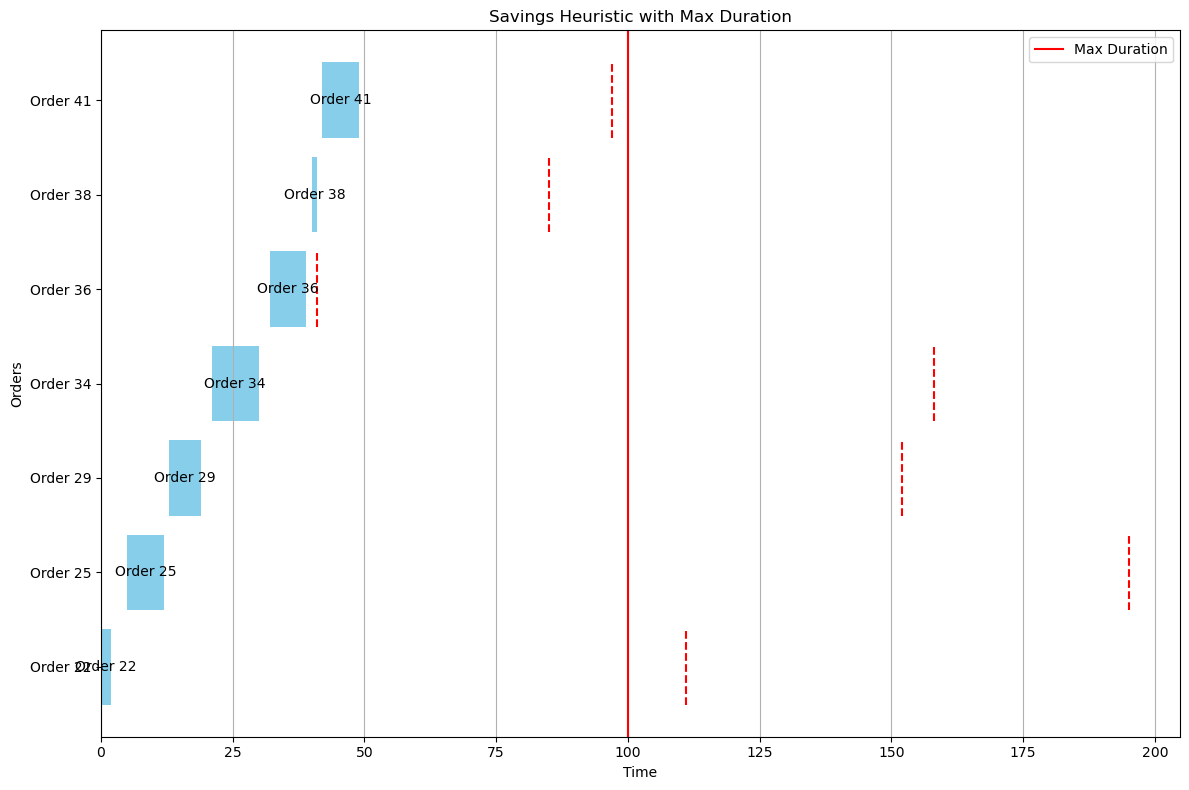

In [10]:
def visualize_savings_gantt(duration, setup, deadline, scheduled_orders, max_duration):
    """
    Visualize the schedule generated by the savings heuristic using a Gantt chart.
    """
    if not scheduled_orders:
        print("No scheduled orders to visualize.")
        return

    num_orders = len(scheduled_orders)
    start_times = [0] * num_orders
    finish_times = [0] * num_orders

    # Calculate start and finish times for each order
    for i, order in enumerate(scheduled_orders):
        if i == 0:
            start_times[i] = 0
        else:
            prev_order = scheduled_orders[i - 1]
            start_times[i] = finish_times[i - 1] + setup[prev_order][order]
        finish_times[i] = start_times[i] + duration[order]

    # Create the Gantt chart
    plt.figure(figsize=(12, 8))

    for i, order in enumerate(scheduled_orders):
        # Plot the bar for each order
        plt.barh(i, finish_times[i] - start_times[i], left=start_times[i], color='skyblue')
        plt.text(start_times[i] + (finish_times[i] - start_times[i]) / 2, i,
                 f"Order {order + 1}", ha='center', va='center', fontsize=10)

        # Plot the deadline line
        plt.vlines(deadline[order], i - 0.4, i + 0.4, color='red', linestyle='--')

    # Plot the maximum duration constraint as a vertical line
    plt.axvline(max_duration, color='red', linestyle='-', label='Max Duration')

    # Set labels and title
    plt.yticks(range(num_orders), [f"Order {order + 1}" for order in scheduled_orders])
    plt.xlabel("Time")
    plt.ylabel("Orders")
    plt.title("Savings Heuristic with Max Duration")
    plt.legend()
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

# Assuming `scheduled_orders` is obtained from the `savings()` function:
scheduled_orders, total_profit, total_duration = savings(duration, profit, dueDate, deadline, tardCost, numberOrders, setup, max_duration)

# Visualize the schedule
visualize_savings_gantt(duration, setup, deadline, scheduled_orders, max_duration)


#### **4.3 Construction Heuristics:**

In [11]:
def construct(duration, profit, dueDate, tardCost, setup, deadline):
    """
    Construct Heuristic for Scheduling.
    Dynamically selects orders to maximize profitability while checking feasibility.
    """
    numberOrders = len(duration)
    remaining_orders = list(range(numberOrders))
    schedule = []
    total_duration = 0
    total_profit = 0

    def score(order, prev_order=None):
        """
        Calculate a score for an order based on profitability, setup time, and tardiness penalties.
        """
        if prev_order is None:
            # First order: score based only on profit and duration
            return profit[order] / duration[order]
        else:
            # Subsequent orders: consider setup time and tardiness penalties
            setup_time = setup[prev_order][order]
            tardiness_penalty = (
                tardCost[order] * max(0, total_duration + setup_time + duration[order] - dueDate[order])
            )
            return profit[order] / (duration[order] + setup_time) - tardiness_penalty

    def construct_feasible(sequence):
        """
        Check the feasibility of the current sequence using `cal()`:
        - No overlapping tasks.
        - No deadlines exceeded.
        """
        start_times, finish_times = cal(duration, setup, sequence)

        # Check constraints for feasibility
        for idx, order in enumerate(sequence):
            if idx > 0:
                # Overlapping tasks check
                if start_times[idx] < finish_times[idx - 1]:
                    return False

            # Deadline exceeded check
            if finish_times[idx] > deadline[order]:
                return False

        return True

    while remaining_orders:
        # Determine the last scheduled order (if any)
        last_order = schedule[-1] if schedule else None

        # Calculate scores for all remaining orders
        scores = [{"order": o, "score": score(o, last_order)} for o in remaining_orders]

        # Select the order with the highest score
        best_order_entry = max(scores, key=lambda x: x["score"])
        best_order = best_order_entry["order"]

        # Tentatively add the order to the schedule
        tentative_schedule = schedule + [best_order]

        # Check feasibility of the tentative schedule
        if construct_feasible(tentative_schedule):
            schedule.append(best_order)
            remaining_orders.remove(best_order)

            # Update total profit
            tardiness_penalty = (
                tardCost[best_order] * max(0, total_duration - dueDate[best_order])
            )
            total_profit += profit[best_order] - tardiness_penalty

            # Update total duration
            setup_time = setup[last_order][best_order] if last_order is not None else 0
            total_duration += duration[best_order] + setup_time
        else:
            # Remove the order from the remaining pool if infeasible
            remaining_orders.remove(best_order)

    return schedule, total_profit, total_duration

In [12]:
print('Results using construct() Greedy Heuristics')
# Loop over each file, read the data, and run the construct function
for file_name in file_names:
    start_time = time.time()  # Record the start time

    # Read input data
    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)
    
    # Assuming construct() provides an initial solution
    schedule, total_profit, total_duration = construct(duration, profit, dueDate, tardCost, setup, deadline)
    
    end_time = time.time()  # Record the end time

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    # Convert to one-based indexing for display
    scheduled_orders = [order + 1 for order in schedule]
    
    # Print the results for this file
    print(f"Results for {file_name}:")
    print(f"Scheduled Orders: {scheduled_orders}")
    print(f"Total Profit: {total_profit}")
    print(f"Total Duration: {total_duration}")
    print(f"Run Time: {elapsed_time:.4f} seconds")
    print("-" * 50)


Results using construct() Greedy Heuristics
Results for OAS0.txt:
Scheduled Orders: [3, 2]
Total Profit: 13.0
Total Duration: 8
Run Time: 0.0030 seconds
--------------------------------------------------
Results for OAS1.txt:
Scheduled Orders: [2, 10, 8, 9, 4]
Total Profit: 380.0
Total Duration: 40
Run Time: 0.0010 seconds
--------------------------------------------------
Results for OAS2.txt:
Scheduled Orders: [9, 14, 4, 1, 6, 12, 5, 7]
Total Profit: 426.703297
Total Duration: 54
Run Time: 0.0020 seconds
--------------------------------------------------
Results for OAS3.txt:
Scheduled Orders: [8, 7, 13, 5, 6, 16, 20, 19, 12, 17, 1, 10]
Total Profit: 787.466679
Total Duration: 77
Run Time: 0.0030 seconds
--------------------------------------------------
Results for OAS4.txt:
Scheduled Orders: [6, 10, 4, 27, 16, 15, 12, 2, 17, 8, 21, 5, 23, 13, 22, 25, 14, 1, 30]
Total Profit: 859.055555
Total Duration: 106
Run Time: 0.0060 seconds
--------------------------------------------------
R

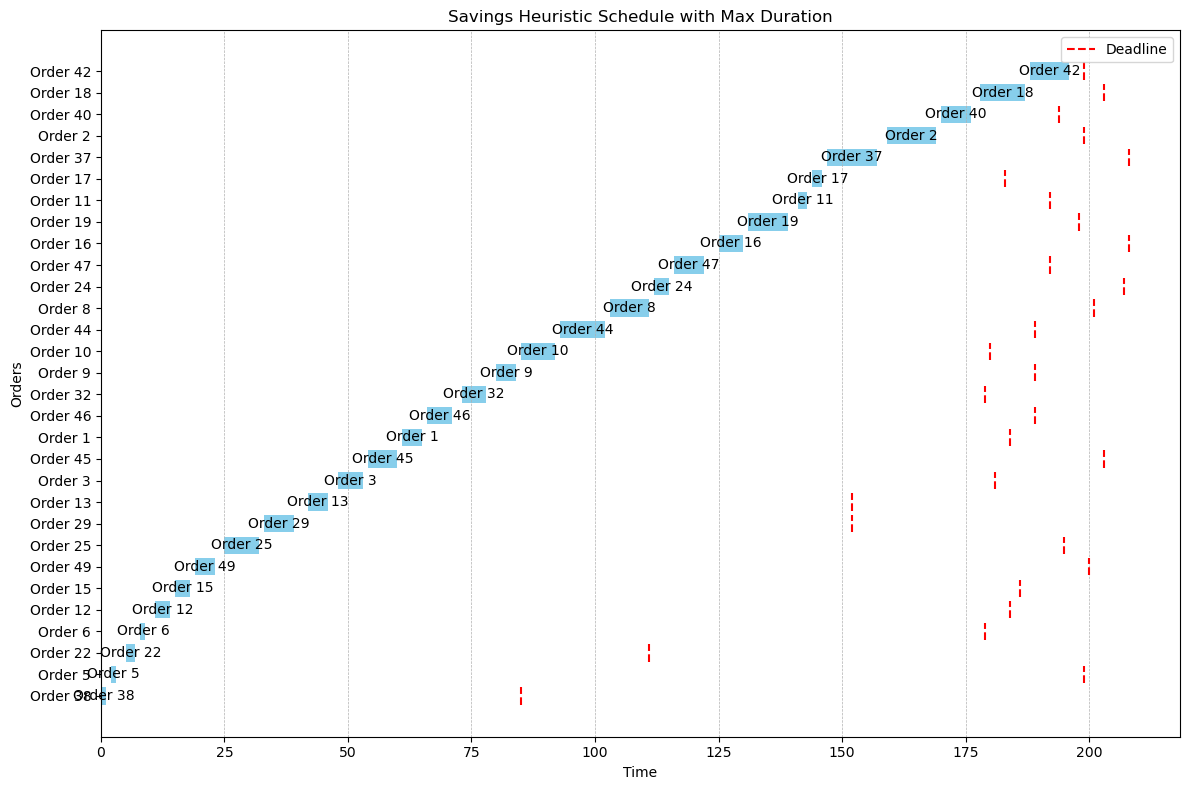

In [13]:
import matplotlib.pyplot as plt

def visualize_savings_gantt(duration, setup, deadline, scheduled_orders, max_duration):
    """
    Visualize the schedule generated by the savings heuristic using a Gantt chart.
    """
    if not scheduled_orders:
        print("No scheduled orders to visualize.")
        return

    num_orders = len(scheduled_orders)
    start_times = [0] * num_orders
    finish_times = [0] * num_orders

    # Calculate start and finish times for each order
    for i, order in enumerate(scheduled_orders):
        if i == 0:
            start_times[i] = 0
        else:
            prev_order = scheduled_orders[i - 1]
            start_times[i] = finish_times[i - 1] + setup[prev_order][order]
        finish_times[i] = start_times[i] + duration[order]

    # Create the Gantt chart
    plt.figure(figsize=(12, 8))

    for i, order in enumerate(scheduled_orders):
        # Plot the bar for each order
        plt.barh(i, finish_times[i] - start_times[i], left=start_times[i], color='skyblue')
        plt.text(start_times[i] + (finish_times[i] - start_times[i]) / 2, i,
                 f"Order {order + 1}", ha='center', va='center', fontsize=10)

        # Plot the deadline line
        plt.vlines(deadline[order], i - 0.4, i + 0.4, color='red', linestyle='--', label='Deadline' if i == 0 else None)

    # Set labels and title
    plt.yticks(range(num_orders), [f"Order {order + 1}" for order in scheduled_orders])
    plt.xlabel("Time")
    plt.ylabel("Orders")
    plt.title("Savings Heuristic Schedule with Max Duration")
    plt.legend(loc='upper right')
    plt.grid(axis='x', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Assuming `scheduled_orders` is obtained from the `savings()` function:
schedule, total_profit, total_duration = construct(duration, profit, dueDate, tardCost, setup, deadline)

# Visualize the schedule
visualize_savings_gantt(duration, setup, deadline, schedule, max_duration)


### 5. Local Search Improvement Heuristics

- ***Move():***

In [14]:
def move(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders):
    """
    Local search using Move.
    Tries to improve the solution by moving an order to a different position or
    adding an order to the schedule.
    """
    def calculate_profit(sequence):
        """
        Evaluates the feasibility and profit of a sequence.
        Returns None if the sequence is infeasible, or the total profit otherwise.
        """
        try:
            start_times, _ = cal(duration, setup, sequence)
            return eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence)
        except Exception:
            return None

    # Track the best solution and its profit
    best_solution = initial_solution.copy()
    best_profit = calculate_profit(best_solution)

    improved = True
    while improved:
        improved = False

        # Try removing each order in the current solution and reinserting it
        for i in range(len(best_solution)):
            # Work on a copy of the current solution
            current_solution = best_solution.copy()
            order_to_move = current_solution.pop(i)  # Remove the order

            for j in range(len(current_solution) + 1):
                tentative_solution = current_solution[:j] + [order_to_move] + current_solution[j:]
                tentative_profit = calculate_profit(tentative_solution)

                if tentative_profit is not None and tentative_profit > best_profit:
                    best_solution = tentative_solution
                    best_profit = tentative_profit
                    improved = True
                    break 

        # Try adding orders not in the current solution
        for order in range(numberOrders):
            if order not in best_solution:
                for j in range(len(best_solution) + 1):
                    tentative_solution = best_solution[:j] + [order] + best_solution[j:]
                    tentative_profit = calculate_profit(tentative_solution)

                    if tentative_profit is not None and tentative_profit > best_profit:
                        best_solution = tentative_solution
                        best_profit = tentative_profit
                        improved = True
                        break 

    return best_solution, best_profit


In [15]:
print('Results using move() Heuristics')
# Loop over each file, read the data, and run the move function
for file_name in file_names:
    start_time = time.time()  # Record the start time

    # Read input data
    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)
    
    # Assuming construct() provides an initial solution
    initial_solution, _, _ = construct(duration, profit, dueDate, tardCost, setup, deadline)
    
    # Apply move local search
    scheduled_orders, improved_profit = move(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)
    
    end_time = time.time()  # Record the end time

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    # Convert to one-based indexing for display
    improved_orders_ = [order + 1 for order in scheduled_orders]
    
    # Print the results for this file
    print(f"Results for {file_name}:")
    print(f"Scheduled Orders: {improved_orders_}")
    print(f"Total Profit: {improved_profit}")
    print(f"Run Time: {elapsed_time:.4f} seconds")
    print("-" * 50)


Results using move() Heuristics
Results for OAS0.txt:
Scheduled Orders: [3, 2]
Total Profit: 13
Run Time: 0.0030 seconds
--------------------------------------------------
Results for OAS1.txt:
Scheduled Orders: [2, 10, 8, 9, 4]
Total Profit: 380
Run Time: 0.0060 seconds
--------------------------------------------------
Results for OAS2.txt:
Scheduled Orders: [9, 4, 14, 6, 1, 5, 7, 12]
Total Profit: 391.500002
Run Time: 0.0289 seconds
--------------------------------------------------
Results for OAS3.txt:
Scheduled Orders: [7, 14, 13, 6, 16, 10, 20, 19, 5, 8, 12, 17, 1]
Total Profit: 872
Run Time: 0.0539 seconds
--------------------------------------------------
Results for OAS4.txt:
Scheduled Orders: [7, 10, 4, 21, 15, 12, 2, 27, 8, 6, 13, 25, 16, 14, 1, 17, 30, 5, 22, 23]
Total Profit: 875
Run Time: 0.4996 seconds
--------------------------------------------------
Results for OAS5.txt:
Scheduled Orders: [9, 22, 37, 1, 39, 30, 20, 36, 6, 32, 28, 29, 25, 24, 35, 7, 10, 14, 16, 23, 8,

In [16]:
def swap(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders):
    """
    Local search using Swap.
    Tries to improve the solution by swapping the positions of two orders in the schedule.
    """
    def calculate_profit(sequence):
        """
        Evaluates the feasibility and profit of a sequence.
        Returns None if the sequence is infeasible, or the total profit otherwise.
        """
        try:
            start_times, _ = cal(duration, setup, sequence)
            return eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence)
        except Exception:
            return None

    # Track the best solution and its profit
    best_solution = initial_solution.copy()
    best_profit = calculate_profit(best_solution)

    improved = True
    while improved:
        improved = False

        # Try swapping each pair of orders
        for i in range(len(best_solution)):
            for j in range(i + 1, len(best_solution)):
                # Swap orders i and j
                current_solution = best_solution.copy()
                current_solution[i], current_solution[j] = current_solution[j], current_solution[i]

                tentative_profit = calculate_profit(current_solution)

                # Update the best solution if the swap improves profit
                if tentative_profit is not None and tentative_profit > best_profit:
                    best_solution = current_solution
                    best_profit = tentative_profit
                    improved = True
                    break
            if improved:  # If improvement was found, restart the search
                break

    return best_solution, best_profit

In [17]:
print('Results using swap() Heuristics')
# Loop over each file, read the data, and run the swap function
for file_name in file_names:
    start_time = time.time()  # Record the start time

    # Read input data
    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)
    
    # Assuming construct() provides an initial solution
    initial_solution, _, _ = construct(duration, profit, dueDate, tardCost, setup, deadline)
    
    # Apply swap local search
    improved_orders, improved_profit = swap(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)
    
    end_time = time.time()  # Record the end time

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    # Convert to one-based indexing for display
    improved_orders_ = [order + 1 for order in improved_orders]
    
    # Print the results for this file
    print(f"Results for {file_name}:")
    print(f"Scheduled Orders: {improved_orders_}")
    print(f"Total Profit: {improved_profit}")
    print(f"Run Time: {elapsed_time:.4f} seconds")
    print("-" * 50)




Results using swap() Heuristics
Results for OAS0.txt:
Scheduled Orders: [3, 2]
Total Profit: 13
Run Time: 0.0020 seconds
--------------------------------------------------
Results for OAS1.txt:
Scheduled Orders: [2, 10, 8, 9, 4]
Total Profit: 380
Run Time: 0.0030 seconds
--------------------------------------------------
Results for OAS2.txt:
Scheduled Orders: [9, 4, 14, 6, 1, 5, 7, 12]
Total Profit: 391.500002
Run Time: 0.0080 seconds
--------------------------------------------------
Results for OAS3.txt:
Scheduled Orders: [13, 7, 8, 5, 6, 16, 20, 19, 12, 17, 1, 10]
Total Profit: 686.933348
Run Time: 0.0050 seconds
--------------------------------------------------
Results for OAS4.txt:
Scheduled Orders: [21, 10, 4, 27, 2, 15, 12, 16, 17, 25, 6, 5, 23, 13, 30, 8, 14, 1, 22]
Total Profit: 861
Run Time: 0.0628 seconds
--------------------------------------------------
Results for OAS5.txt:
Scheduled Orders: [28, 1, 30, 20, 9, 22, 36, 6, 7, 32, 27, 37, 21, 29, 14, 25, 24, 35, 39, 16, 8,

In [18]:
def improve(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders, max_iterations=1000):
    """
    Local search improvement heuristic using Reverse and Swap heuristics.
    Iteratively applies these operators to improve the solution until no further improvement is found.
    """
    def calculate_profit(sequence):
        """
        Evaluates the feasibility and profit of a sequence.
        Returns None if the sequence is infeasible, or the total profit otherwise.
        """
        try:
            start_times, _ = cal(duration, setup, sequence)
            return eval(duration, profit, dueDate, deadline, tardCost, setup, start_times, sequence)
        except Exception:
            return None

    # Initialize with the initial solution
    current_solution = initial_solution[:]
    best_solution = current_solution
    best_profit = calculate_profit(current_solution)

    iteration = 0
    while iteration < max_iterations:
        iteration += 1
        improved = False
       
        # Apply Reverse heuristic
        for i in range(len(current_solution) - 1):
            for j in range(i + 1, len(current_solution)):
                # Reverse the order of orders between i and j
                new_solution = current_solution[:i] + current_solution[i:j + 1][::-1] + current_solution[j + 1:]
                new_profit = calculate_profit(new_solution)
                if new_profit is not None and new_profit > best_profit:
                    best_solution = new_solution
                    best_profit = new_profit
                    improved = True

        # Apply Move heuristic
        moved_solution, moved_profit = move(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)
        if moved_profit > best_profit:
            best_solution = moved_solution
            best_profit = moved_profit
            improved = True

        # If no improvement is found, terminate
        if not improved:
            break

        # Update the current solution for the next iteration
        current_solution = best_solution

    return best_solution, best_profit

In [19]:
print('Results using Improve() Heuristics')

# Loop over each file, read the data, and run the improve function
for file_name in file_names:
    start_time = time.time()  # Record the start time

    # Read input data
    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)
    
    # Generate the initial solution
    initial_solution, _, _ = construct(duration, profit, dueDate, tardCost, setup, deadline)

    # Apply the improve() heuristic
    improved_solution, optimal_profit = improve(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders, max_iterations=1)

    end_time = time.time()  # Record the end time

    # Calculate elapsed time
    elapsed_time = end_time - start_time

    # Print the results for this file
    print(f"Results for {file_name}:")
    print(f"Scheduled Orders: {[order + 1 for order in improved_solution]}")
    print(f"Total Profit: {optimal_profit}")
    print(f"Run Time: {elapsed_time:.4f} seconds")
    print("-" * 50)

Results using Improve() Heuristics
Results for OAS0.txt:
Scheduled Orders: [3, 2]
Total Profit: 13
Run Time: 0.0020 seconds
--------------------------------------------------
Results for OAS1.txt:
Scheduled Orders: [2, 10, 8, 9, 4]
Total Profit: 380
Run Time: 0.0030 seconds
--------------------------------------------------
Results for OAS2.txt:
Scheduled Orders: [9, 4, 14, 6, 1, 5, 7, 12]
Total Profit: 391.500002
Run Time: 0.0140 seconds
--------------------------------------------------
Results for OAS3.txt:
Scheduled Orders: [7, 14, 13, 6, 16, 10, 20, 19, 5, 8, 12, 17, 1]
Total Profit: 872
Run Time: 0.0641 seconds
--------------------------------------------------
Results for OAS4.txt:
Scheduled Orders: [7, 10, 4, 21, 15, 12, 2, 27, 8, 6, 13, 25, 16, 14, 1, 17, 30, 5, 22, 23]
Total Profit: 875
Run Time: 0.2502 seconds
--------------------------------------------------
Results for OAS5.txt:
Scheduled Orders: [9, 22, 37, 1, 39, 30, 20, 36, 6, 32, 28, 29, 25, 24, 35, 7, 10, 14, 16, 23,

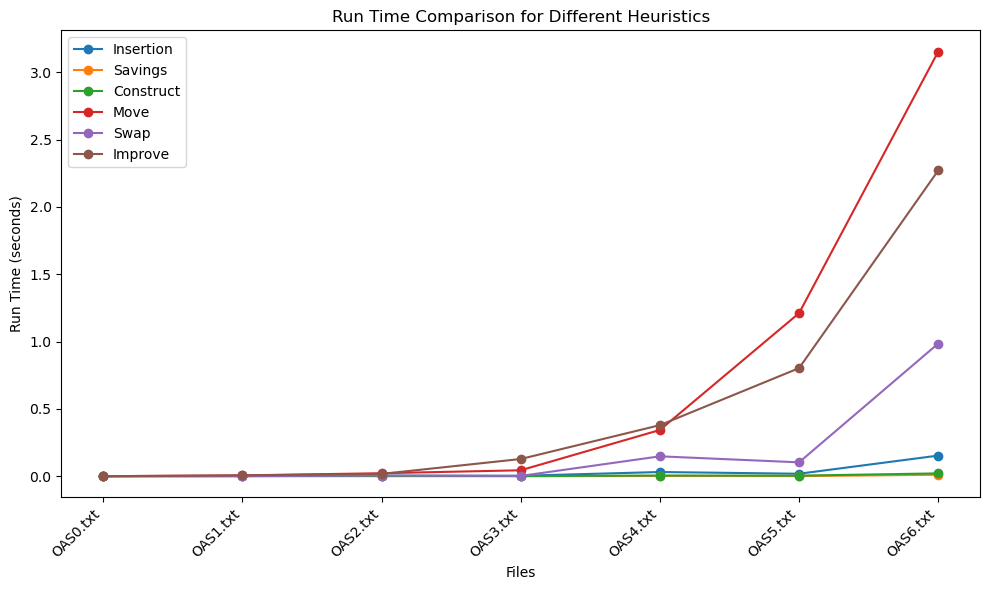

In [20]:
import matplotlib.pyplot as plt
import time
    
# Initialize a dictionary to store the run times for each heuristic
heuristics = ['Insertion', 'Savings', 'Construct', 'Move', 'Swap', 'Improve']
run_times = {heuristic: [] for heuristic in heuristics}

# Loop over each file and collect the run times for each heuristic
for file_name in file_names:
    # Read input data
    duration, profit, dueDate, deadline, tardCost, numberOrders, setup = readInput(file_name)

    # Insertion heuristic
    start_time = time.time()
    scheduled_orders, total_profit = insertion(duration, profit, dueDate, deadline, tardCost, numberOrders, setup)
    end_time = time.time()
    run_times['Insertion'].append(end_time - start_time)

    # Savings heuristic
    start_time = time.time()
    scheduled_orders, total_profit, total_duration = savings(duration, profit, dueDate, deadline, tardCost, numberOrders, setup, max_duration)
    end_time = time.time()
    run_times['Savings'].append(end_time - start_time)

    # Construct heuristic
    start_time = time.time()
    initial_solution, _, _ = construct(duration, profit, dueDate, tardCost, setup, deadline)
    end_time = time.time()
    run_times['Construct'].append(end_time - start_time)

    # Move heuristic
    start_time = time.time()
    scheduled_orders, improved_profit = move(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)
    end_time = time.time()
    run_times['Move'].append(end_time - start_time)

    # Swap heuristic
    start_time = time.time()
    scheduled_orders, improved_profit = swap(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders)
    end_time = time.time()
    run_times['Swap'].append(end_time - start_time)

    # Improve heuristic
    start_time = time.time()
    improved_solution, optimal_profit = improve(duration, profit, dueDate, deadline, tardCost, setup, initial_solution, numberOrders, max_iterations=1)
    end_time = time.time()
    run_times['Improve'].append(end_time - start_time)

# Plot the graph
plt.figure(figsize=(10, 6))

# Plot the run times for each heuristic
for heuristic in heuristics:
    plt.plot(file_names, run_times[heuristic], marker='o', label=heuristic)

# Add labels and title
plt.xlabel('Files')
plt.ylabel('Run Time (seconds)')
plt.title('Run Time Comparison for Different Heuristics')

# Add legend
plt.legend()

# Display the plot
plt.xticks(rotation=45, ha="right") 
plt.tight_layout()
plt.show()


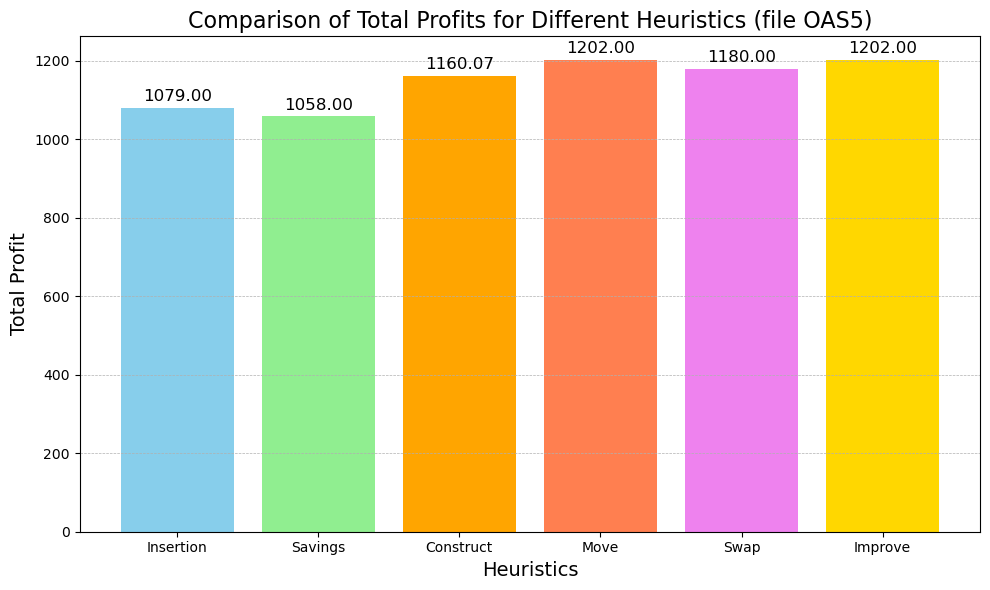

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Example data: Replace these with actual results from your heuristics
heuristics = ["Insertion", "Savings", "Construct", "Move", "Swap", "Improve"]
total_profits = np.array([1079, 1058, 1160.074, 1202, 1180, 1202], dtype=np.float32)  # Example profits for each heuristic

# Define colors for each bar
colors = ["skyblue", "lightgreen", "orange", "coral", "violet", "gold"]

def plot_profit_comparison(heuristics, total_profits):
    """
    Plot a bar chart comparing total profits for different heuristics.

    Parameters:
    heuristics (list): List of heuristic names.
    total_profits (list or np.array): Corresponding total profits achieved by each heuristic.
    """
    plt.figure(figsize=(10, 6))

    # Create the bar chart
    plt.bar(heuristics, total_profits, color=colors)

    # Add labels, title, and grid
    plt.xlabel("Heuristics", fontsize=14)
    plt.ylabel("Total Profit", fontsize=14)
    plt.title("Comparison of Total Profits for Different Heuristics (file OAS5)", fontsize=16)
    plt.grid(axis="y", linestyle="--", linewidth=0.5)

    # Annotate bars with profit values
    for i, profit in enumerate(total_profits):
        plt.text(i, profit + 10, f"{profit:.2f}", ha="center", va="bottom", fontsize=12)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot the comparison
plot_profit_comparison(heuristics, total_profits)
